##### imports

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from itertools import combinations

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

# Data Preparation

In [43]:
df = pd.read_csv('meteologica.txt', delimiter=';')
df.head(3)

,Observacion,U,V,T
0,512,13,-34,2873
1,726,17,-21,2821
2,730,10,-21,2809


## Calculate Wind Speed

In [44]:
def add_wind_speed(df):
    return np.sqrt((df['U'] / 20) ** 2 + (df['V'] / 10) ** 2)

## Calculate Wind Direction

In [45]:
def wind_radians_degrees(df):
    radians = np.arctan2(df['U'], df['V'])
    degrees = (np.degrees(radians) + 360) % 360
    return degrees

## Calculate Wind Direction Sector

In [46]:
def direction_sector(df):
    if df['Direction (degrees)'] >= 315 or df['Direction (degrees)'] < 45:
        return 'North'
    elif df['Direction (degrees)'] >= 45 and df['Direction (degrees)'] < 135:
        return 'East'
    elif df['Direction (degrees)'] >= 135 and df['Direction (degrees)'] < 225:
        return 'South'
    else:
        return 'West'

## Apply Functions

In [47]:
df['Speed (m/ps)'] = df.apply(add_wind_speed, axis=1)
df['Direction (degrees)'] = df.apply(wind_radians_degrees, axis=1)
df['Direction (sector)'] = df.apply(direction_sector, axis=1)

In [48]:
df.head()

,Observacion,U,V,T,Speed (m/ps),Direction (degrees),Direction (sector)
0,512,13,-34,2873,3.461575,159.075498,South
1,726,17,-21,2821,2.265502,141.009006,South
2,730,10,-21,2809,2.158703,154.536655,South
3,844,9,-37,2830,3.727264,166.328693,South
4,948,2,-46,2838,4.601087,177.510447,South


## DataFrames by Sector

In [49]:
north_df = df[df['Direction (sector)'] == 'North']
east_df = df[df['Direction (sector)'] == 'East']
south_df = df[df['Direction (sector)'] == 'South']
west_df = df[df['Direction (sector)'] == 'West']

## Scaler by Sector

In [50]:
pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
pipeline

Pipeline(steps=[('std_scaler', StandardScaler())])

In [51]:
# north_f_df = north_df[['U', 'V', 'Speed (m/ps)', 'Direction (degrees)']]

# north_f_df.head()

# North Linear Regression

In [53]:
X_n = north_df[['U', 'V', 'Speed (m/ps)', 'Direction (degrees)']]
y_n = north_df['Observacion']

X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, 
                                                            y_n, 
                                                            test_size=0.2,
                                                            random_state=42
                                                           )

In [54]:
X_train_n_scaled = pipeline.fit_transform(X_train_n)
X_test_n_scaled = pipeline.fit_transform(X_test_n)

In [55]:
lin_reg_n = LinearRegression()
lin_reg_n.fit(X_train_n_scaled, y_train_n)

display(f'Y-Intercept for north sector: {lin_reg_n.intercept_}')
display(f'Coefficient for north sector: {lin_reg_n.coef_}')

'Y-Intercept for north sector: 252.3637961335677'

'Coefficient for north sector: [  16.57332326 -398.02962575  561.86638151  -12.99349163]'

In [56]:
y_pred_n = lin_reg_n.predict(X_test_n_scaled)

mse_n = round(mean_squared_error(y_test_n, y_pred_n), 2)
rmse_n = round(np.sqrt(mse_n), 2)
mae_n = round(np.mean(np.abs(y_test_n - y_pred_n)), 2)
r2_n = round(r2_score(y_test_n, y_pred_n), 4)

display(f'MSE: {mse_n}')
display(f'RMSE: {rmse_n}')
display(f'MAE: {mae_n}')
display(f'R-squared: {r2_n}')

'MSE: 34818.48'

'RMSE: 186.6'

'MAE: 140.8'

'R-squared: 0.5129'

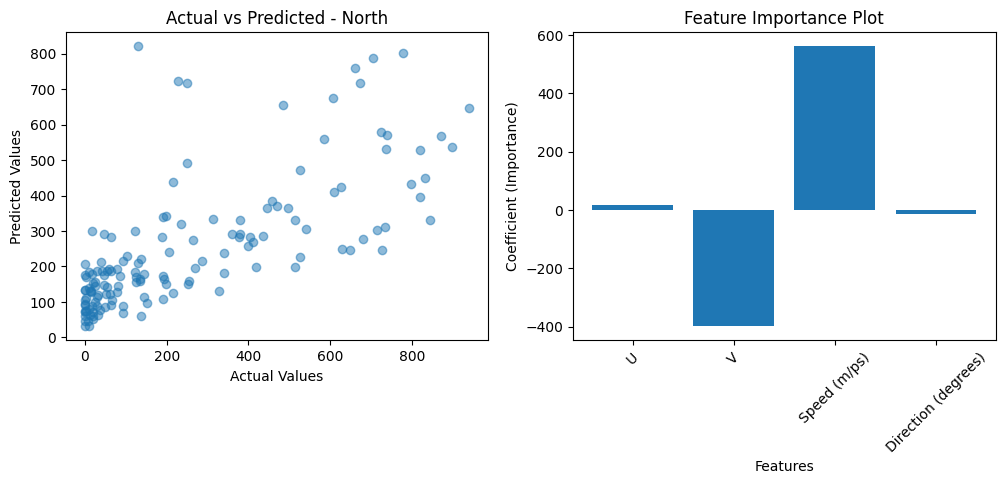

<Figure size 640x480 with 0 Axes>

In [62]:
errors_multi_n = [mse_n, mae_n]
residuals_n = y_test_n - y_pred_n

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.scatter(y_test_n, y_pred_n, alpha=0.5)
plt.title('Actual vs Predicted - North')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

x_range = np.linspace(min(y_test_n), max(y_test_n), 100)  # Create a range of x values
regression_line = x_range  # Replace this with your actual regression equation
plt.plot(x_range, regression_line, color='red')
feature_importance_n = lin_reg_n.coef_

plt.subplot(122)
plt.bar(X_n_df.columns, feature_importance_n)
plt.title('Feature Importance Plot')
plt.xlabel('Features')
plt.ylabel('Coefficient (Importance)')
plt.xticks(rotation=45)
plt.show()

plt.tight_layout()
plt.show()